HW3

Qifan Chen

9166932624

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

(b): Select the first 130 non-recurrent cases and the first 37 recurrent cases as your training set. Add record #197 in the data set to your training set as well.

References:
https://stackoverflow.com/questions/75956209/dataframe-object-has-no-attribute-append
https://towardsdatascience.com/fix-attributeerror-dataframe-object-has-no-attribute-append-9bc1557cc929

In [104]:
data_path = "../data/wpbc.data"
usecols = [1] + list(range(3,35))
df = pd.read_csv(data_path, header=None, usecols=usecols)
df

,1,3,4,5,6,7,8,9,10,11,...,25,26,27,28,29,30,31,32,33,34
0,N,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,0.07055,0.1865,...,139.70,1436.0,0.11950,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5
1,N,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,184.60,2019.0,0.16220,0.6656,0.7119,0.26540,0.4601,0.11890,3.0,2
2,N,21.37,17.44,137.50,1373.0,0.08836,0.11890,0.12550,0.08180,0.2333,...,159.10,1949.0,0.11880,0.3449,0.3414,0.20320,0.4334,0.09067,2.5,0
3,N,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300,2.0,0
4,R,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,152.20,1575.0,0.13740,0.2050,0.4000,0.16250,0.2364,0.07678,3.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,N,22.52,21.92,146.90,1597.0,0.07592,0.09162,0.06862,0.06367,0.1728,...,162.10,1902.0,0.08191,0.1319,0.1056,0.09378,0.2061,0.05788,6.0,2
194,N,15.44,31.18,101.00,740.4,0.09399,0.10620,0.13750,0.06500,0.1735,...,112.60,929.0,0.12720,0.2362,0.2975,0.12860,0.2914,0.08024,1.5,0
195,N,17.17,29.19,110.00,915.3,0.08952,0.06655,0.06583,0.05068,0.1793,...,132.50,1295.0,0.12610,0.1572,0.2141,0.09520,0.3362,0.06033,3.7,0
196,R,21.42,22.84,145.00,1440.0,0.10700,0.19390,0.23800,0.13180,0.1884,...,198.30,2375.0,0.14980,0.4379,0.5411,0.22150,0.2832,0.08981,3.0,?


In [105]:
num_N = 130
num_R = 37
train_data = pd.concat([df[df.iloc[:,0] == "N"][:num_N],
                        df[df.iloc[:,0] == "R"][:num_R],
                        df.iloc[196,:].to_frame().T])
test_data = df.drop(train_data.index)

#Randomly split the training and test sets from the original dataset to ensure consistency in the number of samples
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data.shape, test_data.shape, df.shape


((168, 33), (30, 33), (198, 33))

(c)There are four instances in your training set that are missing the lymph node feature (denoted as ?). This is not a very severe issue, so replace the missing features with the median of the lymph node feature in your training set.

In [106]:
num_q = np.count_nonzero(train_data.iloc[:,-1] == '?')
print("---------------------------------")
print(f"Before modifying, the number of ? : {num_q}")
# replace ? to mean of other values
ly_np = np.asarray(train_data[train_data.iloc[:,-1] != "?"].iloc[:,-1], dtype=float)
ly_mean = ly_np.mean()
train_data.iloc[:,-1] = train_data.iloc[:,-1].replace('?',ly_mean)

num_q = np.count_nonzero(train_data.iloc[:,-1] == '?')
print(f"After modifying, the number of ? : {num_q}")
print("---------------------------------")

---------------------------------
Before modifying, the number of ? : 4
After modifying, the number of ? : 0
---------------------------------


(d):Binary Classification Using Na ̈ıve Bayes’ Classifiers

In [107]:
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168, 32), (168,), (30, 32), (30,))

i.Solve the problem using a Na ̈ıve Bayes’ classifier. Use Gaussian class conditional distributions. Report the confusion matrix, ROC, precision, recall, F1 score, and AUC for both the train and test data sets

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_results(cm):

    TP = np.diag(cm)  
    FP = cm.sum(axis=0) - TP  
    FN = cm.sum(axis=1) - TP  
    TN = cm.sum() - (FP + FN + TP)  

   
    TPR = TP / (TP + FN)
   
    TNR = TN / (TN + FP)
   
    PPV = TP / (TP + FP)

    F1 = 2 * PPV * TPR / (PPV + TPR)
    
    return TPR, TNR, PPV, F1

def show_results(gnb, X, y, name):
    y_pred = gnb.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred, labels=gnb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
    TPR, TNR, PPV, F1 = get_results(cm)
    print("---------------------------------")
    print(f"{name} recall : {TPR[1]:.2f}")
    print(f"{name} precision : {PPV[1]:.2f}")
    print(f"{name} F1 Score : {F1[1]:.2f}")
    print(f"{name} confusion matrix：")
    print("---------------------------------")
    disp.plot()
    plt.show()


---------------------------------
train recall : 0.47
train precision : 0.36
train F1 Score : 0.41
train confusion matrix：
---------------------------------


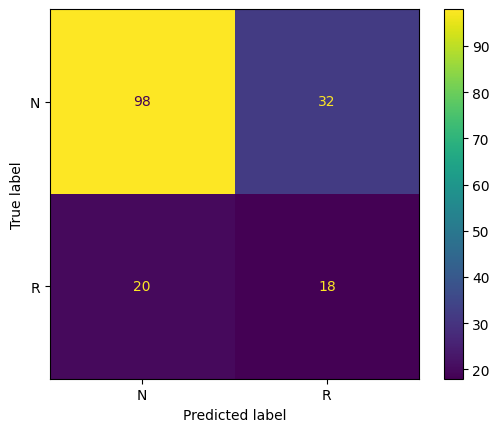

---------------------------------
test recall : 0.33
test precision : 0.30
test F1 Score : 0.32
test confusion matrix：
---------------------------------


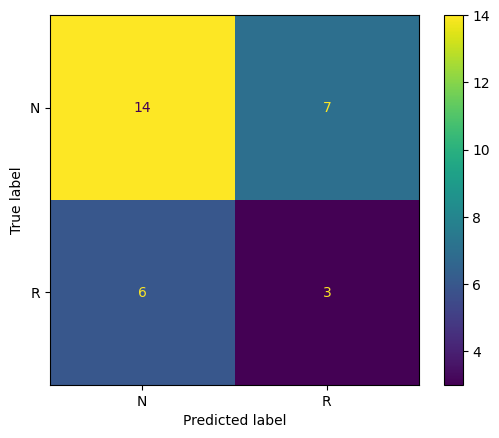

In [109]:
gnb = GaussianNB().fit(X_train, y_train)
show_results(gnb, X_train, y_train, 'train')
show_results(gnb, X_test, y_test, 'test')

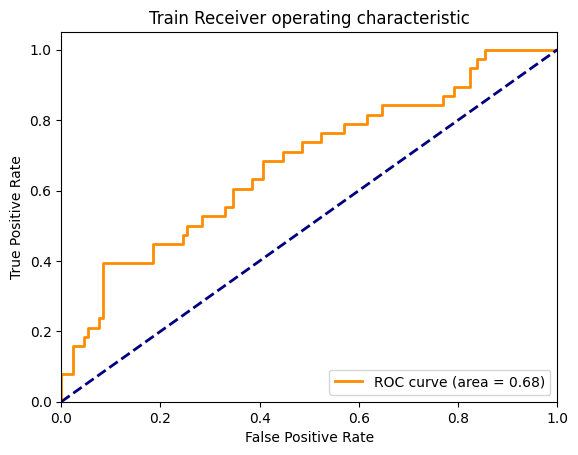

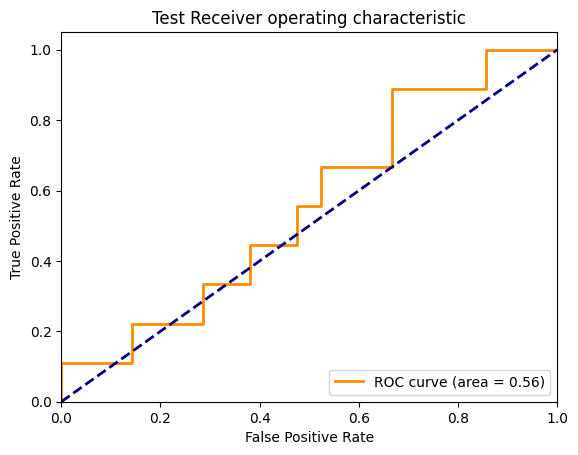

In [110]:

def plot_roc(y_true, y_score, name=None):
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label='R')
    area = auc(fpr, tpr)
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % area,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name+" Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    

scores = gnb.predict_proba(X_train)[:, 1]
plot_roc(y_train, scores, name="Train")
scores = gnb.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test")

ii.This data set is rather imbalanced. Balance your data set using SMOTE, by downsampling the common class in the training set to 90 instances and upsampling the uncommon class to 90 instances. Use k = 5 nearest neighbors in SMOTE. Remember not to change the balance of the test set. Report the confusion matrix, ROC, precision, recall, F1 score, and AUC for both the train and test data sets. Does SMOTE help?

In [111]:
print("---------------------------------")
print("Original: ", Counter(y_train))
sm = SMOTE(sampling_strategy={'N':130, 'R':90},random_state=42, k_neighbors=5)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print("adding new data for minority   : ", Counter(y_sm))
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_sm, y_sm)
print("delete some data from majority : ", Counter(y_resampled))
print("---------------------------------")

---------------------------------
Original:  Counter({'N': 130, 'R': 38})
adding new data for minority   :  Counter({'N': 130, 'R': 90})
delete some data from majority :  Counter({'N': 90, 'R': 90})
---------------------------------


---------------------------------
Resampled train recall : 0.66
Resampled train precision : 0.69
Resampled train F1 Score : 0.67
Resampled train confusion matrix：
---------------------------------


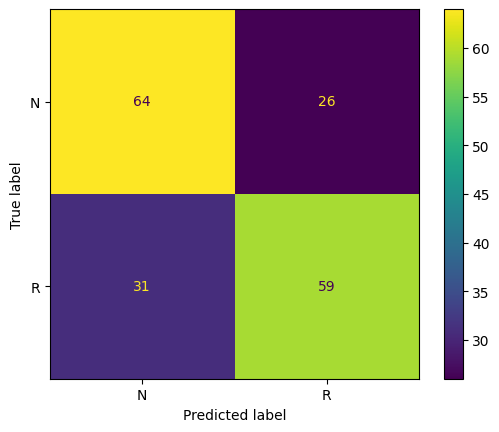

---------------------------------
Original train after resample recall : 0.47
Original train after resample precision : 0.36
Original train after resample F1 Score : 0.41
Original train after resample confusion matrix：
---------------------------------


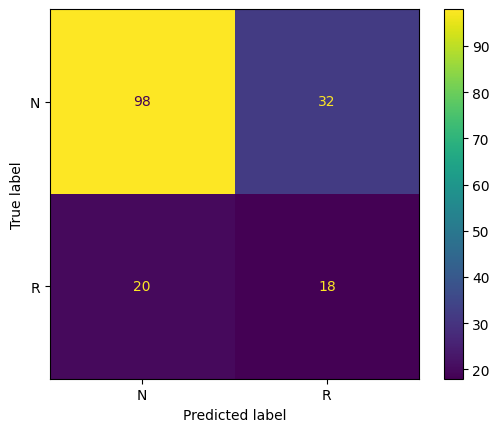

---------------------------------
Test after resample recall : 0.33
Test after resample precision : 0.30
Test after resample F1 Score : 0.32
Test after resample confusion matrix：
---------------------------------


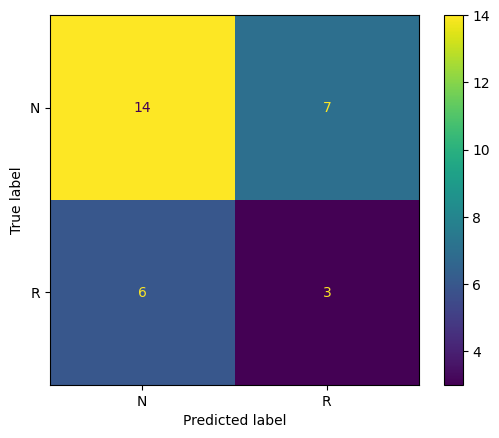

---------------------------------
Test before resample recall : 0.33
Test before resample precision : 0.30
Test before resample F1 Score : 0.32
Test before resample confusion matrix：
---------------------------------


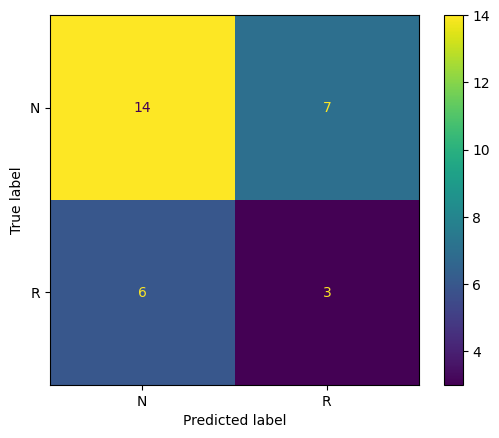

In [112]:
from sklearn.naive_bayes import GaussianNB

# Use X_resampled and y_resampled to train model
gnb_resampled = GaussianNB()
gnb_resampled.fit(X_resampled, y_resampled)
show_results(gnb_resampled, X_resampled, y_resampled, 'Resampled train')

# Use X_train and y_train to train model
gnb_resampled.fit(X_train, y_train)
show_results(gnb_resampled, X_train, y_train, 'Original train after resample')

# Use X_test and y_test to test
show_results(gnb_resampled, X_test, y_test, 'Test after resample')

# Use gnb to test
show_results(gnb, X_test, y_test, 'Test before resample')


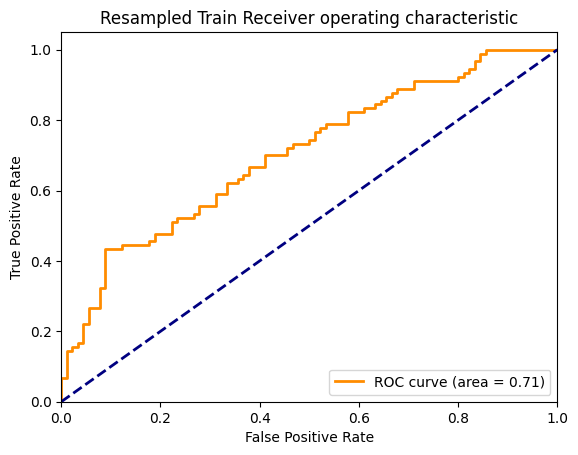

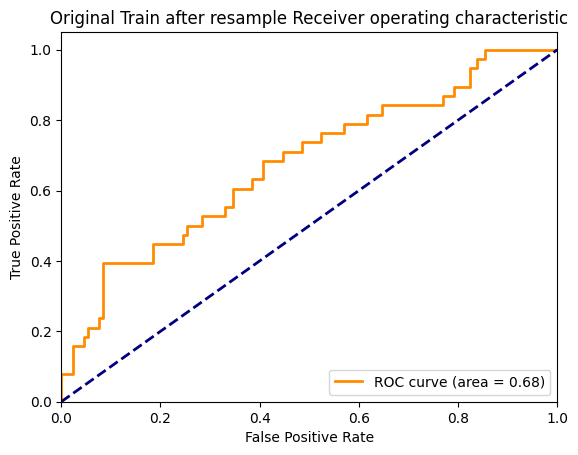

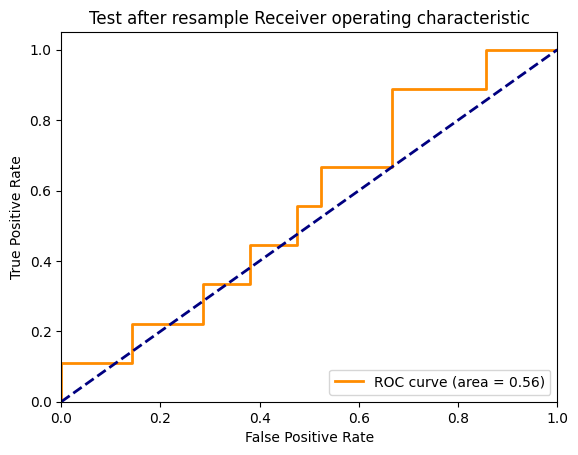

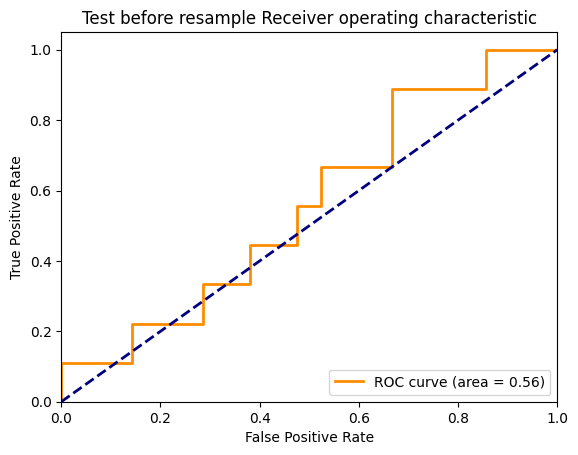

In [113]:
scores = gnb_resampled.predict_proba(X_resampled)[:, 1]
plot_roc(y_resampled, scores, name="Resampled Train")

scores = gnb_resampled.predict_proba(X_train)[:, 1]
plot_roc(y_train, scores, name="Original Train after resample")

scores = gnb_resampled.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test after resample")

scores = gnb.predict_proba(X_test)[:, 1]
plot_roc(y_test, scores, name="Test before resample")

Compared with the previous results, we can find that SMOTE can help our test, but the help is not so obvious